In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import accuracy_score

In [3]:
flow = pd.read_pickle('data/soroe_13_19.pkl')

In [4]:
flow = flow[flow.index.date > datetime.date(2013, 11, 28)] 

## I rearrange the dataset s.t. each row represents one day and each column is flow on a given hour of that day. Afterwards I normalise each day s.t. 07:00 flow is 1. Hence i am checking the proportionality throughout the day and not the absolute values

In [24]:
def reorganise_data(df):
    
    flow_dict = {}
    for h in range(24):
        flow = df[df.index.hour == h]
        flow.index = flow.index.strftime('%Y-%m-%d')
        flow = flow.rename(columns={'flow' : h})
        flow_dict[h] = flow
        
    concat_list = [flow_dict[key] for key in flow_dict.keys()]
    
    return pd.concat(concat_list, axis=1)

In [25]:
def normaliser(df):
    
    for row in range(df.shape[0]):
        
        df.iloc[row, :] = df.iloc[row, :]/df.iloc[row, 7]
        
    return df
    

In [26]:
data = reorganise_data(flow)
data = normaliser(data)

In [41]:
data.dropna(axis=0, how='any', inplace=True)

## After cleaning the data, I use the KMeans estimator 

In [42]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data)

In [43]:
data['wd_label'] = kmeans.labels_

In [44]:
data_0 = data[data.wd_label == 0]
data_1 = data[data.wd_label == 1]

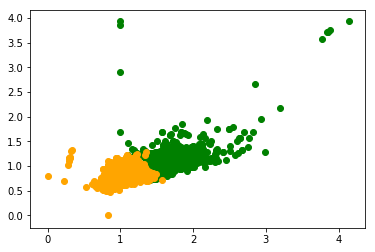

In [45]:
plt.scatter(data_0[10], data_0[20], color='green')
plt.scatter(data_1[10], data_1[20], color='orange')

plt.show()

In [50]:
data.wd_label.to_pickle('./data/wd_label.pkl')

... And it does a pretty good job seperating

## Next we load the old wd-nwd data, and see how well we match

In [47]:
old_fe = pd.read_pickle('data/feature_engineering.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'data/feature_engineering.pkl'

In [13]:
old_fe_daily = old_fe.resample('D').mean()
old_wd = old_fe_daily['workday']
new_wd = data.wd_label

In [14]:
accuracy_score(old_wd, new_wd).round(3)

0.848

Which means we have 15% of all days classified wrongly, so now i check which days, that is

In [15]:
wd = pd.concat([new_wd, old_wd], axis=1)

In [16]:
wd['days_of_interest'] = ((wd.wd_label == 1) & (wd.workday == 0)) | ((wd.wd_label == 0) & (wd.workday == 1))

In [17]:
inspections = wd[wd.days_of_interest == 1]

In [18]:
inspections.head(3)

wd_label  workday  days_of_interest
2013-12-23         1      0.0              True
2013-12-27         1      0.0              True
2013-12-30         1      0.0              True

 Kmeans is pretty good at detecting nonworkdays.

## Checking which days in the summer period are nwd in the eyes of the algorithm

In [57]:
wd.index = pd.to_datetime(wd.index, format='%Y-%m-%d')

In [58]:
wd_2014 = wd[(wd.index > datetime.datetime(2013, 12, 31, 23)) & (wd.index < datetime.datetime(2015, 1, 1))]
wd_2015 = wd[(wd.index > datetime.datetime(2014, 12, 31, 23)) & (wd.index < datetime.datetime(2016, 1, 1))]
wd_2016 = wd[(wd.index > datetime.datetime(2015, 12, 31, 23)) & (wd.index < datetime.datetime(2017, 1, 1))]
wd_2017 = wd[(wd.index > datetime.datetime(2016, 12, 31, 23)) & (wd.index < datetime.datetime(2018, 1, 1))]
wd_2018 = wd[(wd.index > datetime.datetime(2017, 12, 31, 23)) & (wd.index < datetime.datetime(2019, 1, 1))]

In [59]:
wd_2014.rename(columns={'wd_label' : '2014'}, inplace=True)
wd_2015.rename(columns={'wd_label' : '2015'}, inplace=True)
wd_2016.rename(columns={'wd_label' : '2016'}, inplace=True)
wd_2017.rename(columns={'wd_label' : '2017'}, inplace=True)
wd_2018.rename(columns={'wd_label' : '2018'}, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [60]:
wd_2014.index = wd_2014.index.strftime('%m-%d')
wd_2015.index = wd_2015.index.strftime('%m-%d')
wd_2016.index = wd_2016.index.strftime('%m-%d')
wd_2017.index = wd_2017.index.strftime('%m-%d')
wd_2018.index = wd_2018.index.strftime('%m-%d')

In [62]:
days = pd.concat([wd_2014['2014'], wd_2015['2015'], wd_2016['2016'], wd_2017['2017'], wd_2018['2018']], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [64]:
days['sum'] = days['2014'] + days['2015'] + days['2016'] + days['2017'] + days['2018']

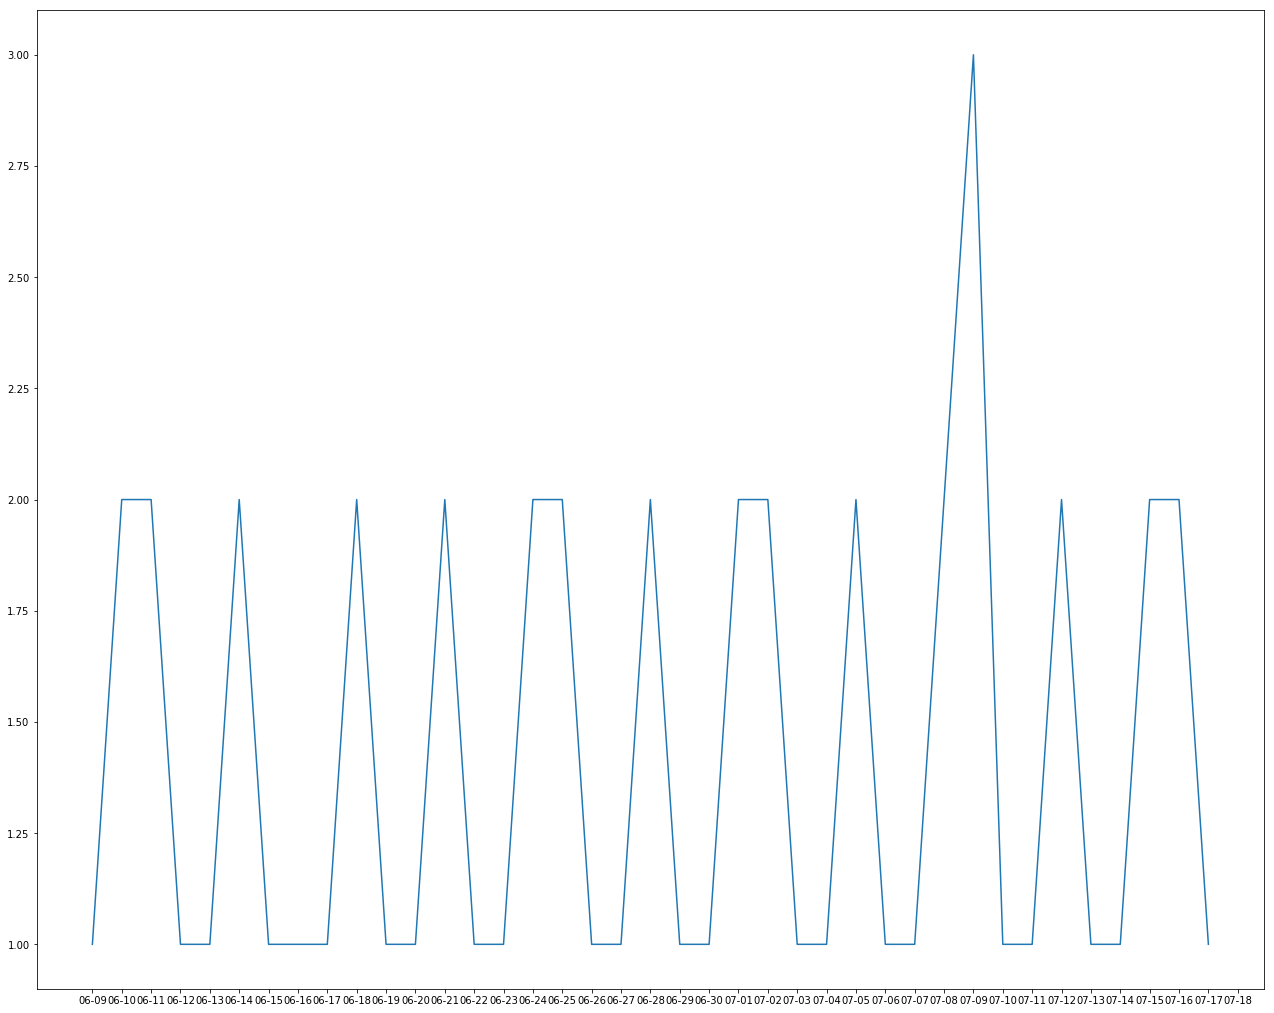

In [93]:
plt.figure(figsize=(22, 18))
plt.plot(days['sum'][160:270])
plt.show()

Der ser generelt ikke ud til at være ferie-stemning i løbet af sommeren - KMeans mener, at dagene er mere hverdag-agtige, end de er Non-workday

## Turning it into a class

In [25]:
class NWDDetector(object):
    
    def __init__(self, data):
        self.data = data 
        
    def _pivot_data(self):
    
    
        flow_dict = {}
        for h in range(24):
            flow = self.data[self.data.index.hour == h]
            flow.index = flow.index.strftime('%Y-%m-%d')
            flow = flow.rename(columns={'flow' : h})
            flow_dict[h] = flow

        concat_list = [flow_dict[key] for key in flow_dict.keys()]

        return pd.concat(concat_list, axis=1)

    def _normaliser(self):

        df = self._pivot_data()
        
        for row in range(df.shape[0]):

            df.iloc[row, :] = df.iloc[row, :]/df.iloc[row, 7]

        return df
    
    def clustering_data(self):
        
        df = self._normaliser()
        df = df[np.isfinite(df[0])]
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(df)
        df['wd_label'] = kmeans.labels_
        
        df.index = pd.to_datetime(df.index, format='%Y-%m-%d') 
        
        return df['wd_label'].resample('H').pad()

In [26]:
nwd = NWDDetector(flow)

In [28]:
d = nwd.clustering_data()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



And it works ...

In [31]:
d.to_pickle('data/wd.pkl')